<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.Spaceship-Titanic/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [14]:
from google.colab import drive

import numpy as np

import pandas as pd

import os

## PEP8 standard

In [2]:
%%capture
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

from nbpep8.nbpep8 import pep8

## Importing custom packages

In [18]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        !wget -O {file} {url} {file}

git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [19]:
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model

def reload_modules(modules):
    for module in modules:
        importlib.reload(module)

reload_modules(
    [
        path_manager,
        sklearn_transformers,
        sklearn_utils,
        model
    ]
)

from path_manager import PathManager
from sklearn_transformers import ColumnDropper
from sklearn_utils import inf_statistics
from model import Model

# Set up paths

In [5]:
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/'

PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = gdrive_path + 'ML/Competitions/6.SpaceshipTitanic/'

manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

Mounted at /content/gdrive
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Data/preproc_trial_1 already exists
/content/gdrive/MyDrive/ML/Competitions/6.SpaceshipTitanic/Models/trial_1 already exists


# Fixing seed

In [8]:
RANDOM_SEED = 42

np.random.seed(42)

# Download the data

In [6]:
os.listdir(manager.data_trial_path)

['train_processed.csv',
 'trainval_processed.csv',
 'test_sample_processed.csv',
 'test_processed.csv']

In [10]:
df_trainval = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'trainval_processed.csv'
    )
)
df_trainval.shape

(6954, 18)

In [13]:
df_test_sample = pd.read_csv(
    os.path.join(
        manager.data_trial_path,
        'test_sample_processed.csv'
    )
)
df_test_sample.shape

(1739, 18)

# Define models

In [21]:
from sklearn.linear_model import LogisticRegression

In [33]:
LogRegModel = Model(
    LogisticRegression(),
    'LogReg',
    [
        
    ],
    [

    ]
)

In [34]:
all_models = {
    model.name: model
    for model in [
        LogRegModel
    ]
}

In [39]:
df_trainval.isna().sum()

Unnamed: 0      0
0               0
1               0
2               0
3               0
4               0
5               0
6               0
7               0
8               0
9               0
10              0
11              0
12              0
13              0
14            168
15            158
16              0
dtype: int64

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
LogReg                      nan               nan                       nan                 nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1514, in fit
    accept_large_sparse=solver not in ["liblinear", "sag", "saga"],
  File "/usr/local/lib/python3.7/dist-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/loc

{'LogReg': {'fit_time': array([0.00584769, 0.0059917 , 0.00479126, 0.00446558, 0.00444722]),
  'score_time': array([0., 0., 0., 0., 0.]),
  'test_score': array([nan, nan, nan, nan, nan]),
  'train_score': array([nan, nan, nan, nan, nan])}}

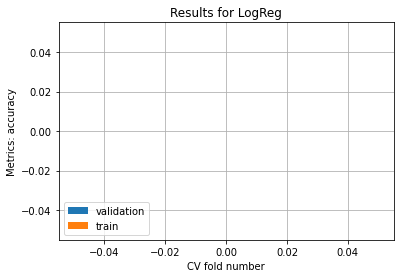

In [35]:
from sklearn_utils import plot_cv_results


plot_cv_results(
    sklearn_models_dict_={
        name: model.model
        for name, model in all_models.items()
    },
    X_=df_trainval.values[:, :-1],
    Y_=df_trainval.values[:, -1],
    cv_=5,
    scoring_='accuracy'
)